# Predecir el precio de cierre diario de Bitcoin

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
from tsxv.splitTrainValTest import split_train_val_test_groupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor        
from statsmodels.tsa.stattools import bds
from joblib import load


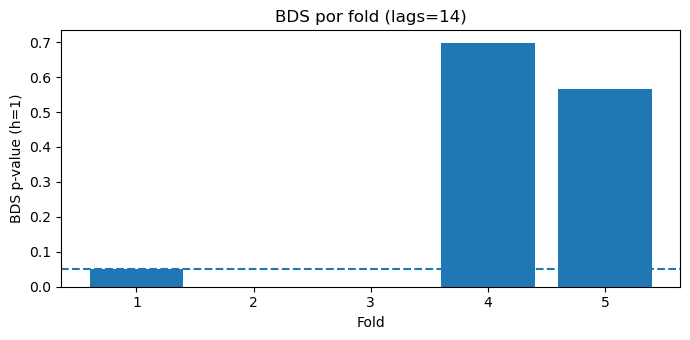

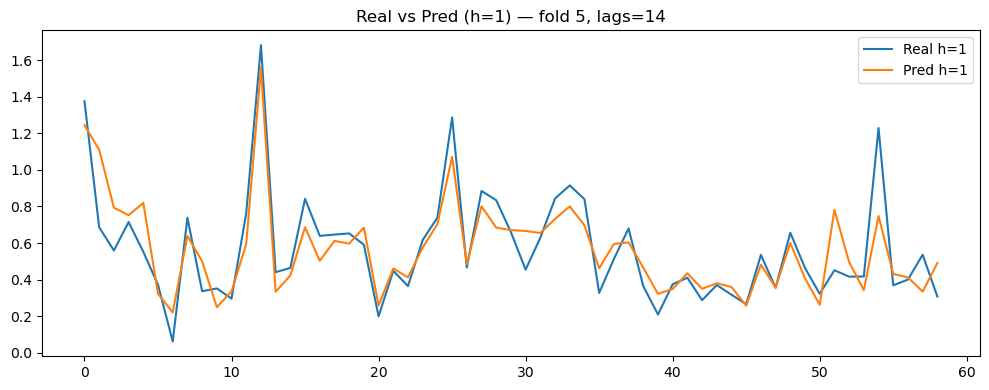

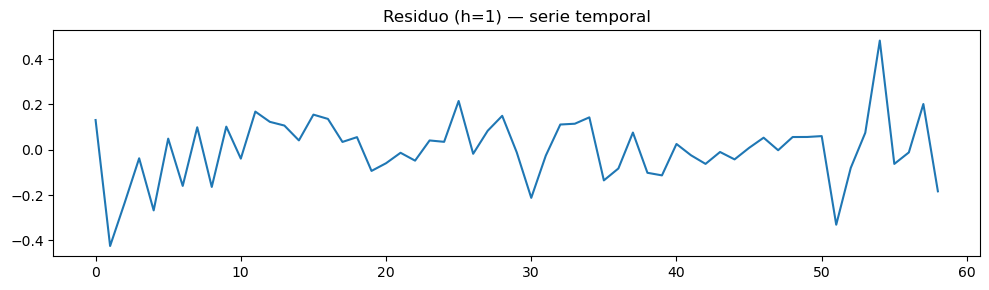

<Figure size 600x300 with 0 Axes>

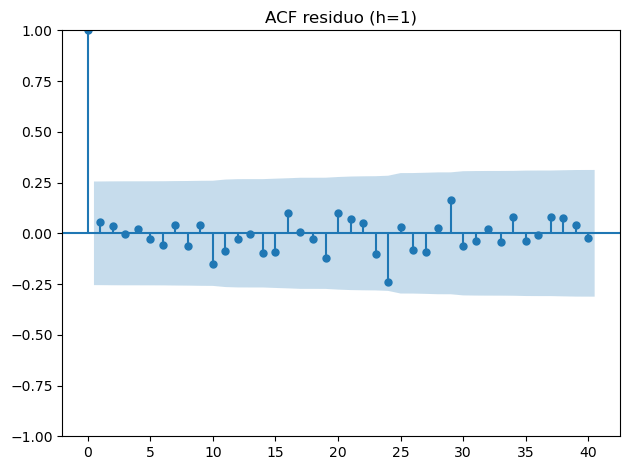

In [3]:
art = load("artifacts/training_artifacts.joblib")
results_lags = art["results_lags"]
lags_list    = art["lags_list"]
H            = art["n_steps_forecast"]

lag = 14  # el que quieras analizar
d = results_lags[lag]['dict_rmse']

# BDS por fold en residuos h=1
fold_ids = sorted(map(int, d.keys()))
bds_pvals = []
for f in fold_ids:
    resid_h1 = (d[str(f)]['ytest_real'][:,0] - d[str(f)]['yhat_test'][:,0]).ravel()
    res = bds(resid_h1, max_dim=2)
    try:    p = float(np.atleast_1d(res.pvalue)[0])
    except: _, p_arr = res; p = float(np.atleast_1d(p_arr)[0])
    bds_pvals.append(p)

# Plot p-values BDS por fold
plt.figure(figsize=(7,3.5))
plt.bar([i+1 for i in fold_ids], bds_pvals)
plt.axhline(0.05, ls='--')
plt.xlabel("Fold"); plt.ylabel("BDS p-value (h=1)")
plt.title(f"BDS por fold (lags={lag})"); plt.tight_layout(); plt.show()

# Serie temporal: h=1 real vs predicho y residuo (mejor fold)
best = int(np.argmin([d[str(i)]['rmse_test'] for i in fold_ids]))
y_true_h1 = d[str(best)]['ytest_real'][:,0]
y_pred_h1 = d[str(best)]['yhat_test'][:,0]
resid = y_true_h1 - y_pred_h1

plt.figure(figsize=(10,4))
plt.plot(y_true_h1, label="Real h=1"); plt.plot(y_pred_h1, label="Pred h=1")
plt.title(f"Real vs Pred (h=1) — fold {best+1}, lags={lag}"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,3))
plt.plot(resid); plt.title("Residuo (h=1) — serie temporal"); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3))
plot_acf(resid, lags=40); plt.title("ACF residuo (h=1)"); plt.tight_layout(); plt.show()

In [4]:

# elige el lag que quieres analizar
lag_to_check = 14  # 7, 14, 21, 28
d = results_lags[lag_to_check]['dict_rmse']

fold_ids = sorted(map(int, d.keys()))
bds_stats, bds_pvals = [], []

for f in fold_ids:
    # Residuos del horizonte 1 en TEST (desescalados)
    resid = (d[str(f)]['ytest_real'][:, 0] - d[str(f)]['yhat_test'][:, 0]).ravel()

    # BDS (m=2). La API cambia según versión; manejamos ambas.
    res = bds(resid, max_dim=2)
    try:
        pval = float(np.atleast_1d(res.pvalue)[0])
        stat = float(np.atleast_1d(res.statistic)[0])
    except AttributeError:
        stat_arr, pval_arr = res
        pval = float(np.atleast_1d(pval_arr)[0])
        stat = float(np.atleast_1d(stat_arr)[0])

    bds_stats.append(stat)
    bds_pvals.append(pval)

    # Guardar en el dict (útil para tablas posteriores)
    d[str(f)]['resid_test_h1'] = resid
    d[str(f)]['bds_stat_h1']   = stat
    d[str(f)]['bds_pval_h1']   = pval

print("p-values BDS (h=1) por fold:", [f"{p:.4f}" for p in bds_pvals])
print("Promedio p-value:", float(np.nanmean(bds_pvals)))


p-values BDS (h=1) por fold: ['0.0495', '0.0005', '0.0002', '0.6988', '0.5673']
Promedio p-value: 0.26326814878559074


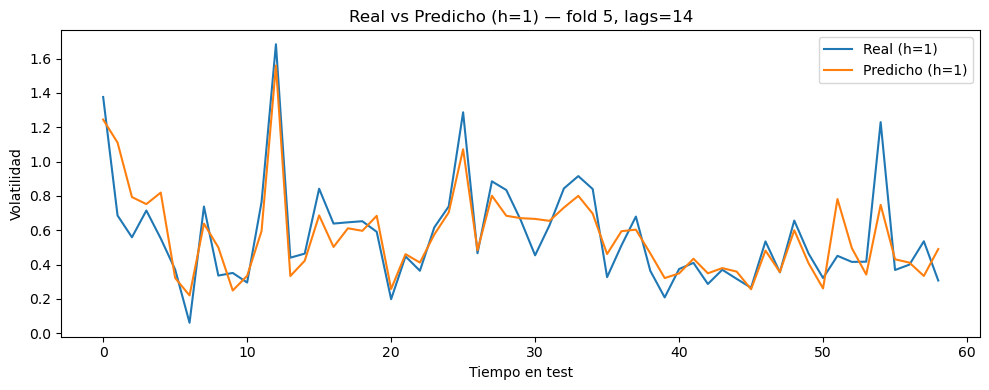

In [5]:
lag = 14
d = results_lags[lag]['dict_rmse']
fold_ids = sorted(map(int, d.keys()))
best = int(np.argmin([d[str(i)]['rmse_test'] for i in fold_ids]))

y_true_h1 = d[str(best)]['ytest_real'][:, 0]
y_pred_h1 = d[str(best)]['yhat_test'][:, 0]

plt.figure(figsize=(10,4))
plt.plot(y_true_h1, label='Real (h=1)')
plt.plot(y_pred_h1, label='Predicho (h=1)')
plt.title(f'Real vs Predicho (h=1) — fold {best+1}, lags={lag}')
plt.xlabel('Tiempo en test'); plt.ylabel('Volatilidad')
plt.legend(); plt.tight_layout(); plt.show()


In [6]:
alpha = 0.05
for f, p in zip(fold_ids, bds_pvals):
    verdict = "no rechazo iid" if p > alpha else "rechazo iid"
    print(f"Fold {f+1}: p={p:.4f} → {verdict}")


Fold 1: p=0.0495 → rechazo iid
Fold 2: p=0.0005 → rechazo iid
Fold 3: p=0.0002 → rechazo iid
Fold 4: p=0.6988 → no rechazo iid
Fold 5: p=0.5673 → no rechazo iid
